# 光刻胶计算工具 - 数学公式与代码整理



## 目录
1. Dill模型公式 (4个公式)
2. Enhanced Dill模型公式 (5个公式)
3. CAR模型公式 (4个公式)
4. 正弦波公式 (3种维度)


In [ ]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

print("环境设置完成！")


# 1. Dill模型公式

Dill模型主要适用于薄胶层（< 3μm）的光刻胶曝光过程建模。

### 1.1 Dill模型 - 核心关系式

**数学公式：**
```
M(x,z) = e^(-C · D(x,z))
```

**参数说明：**
- M(x,z): 位置(x,z)处的归一化光敏剂浓度，M=1表示未曝光区域，M=0表示完全曝光区域
- C: 光敏速率常数，表示光刻胶对光的敏感程度，单位: cm²/mJ
- D(x,z): 位置(x,z)处的曝光剂量，单位: mJ/cm²


In [ ]:
# 后端代码实现 - dill_model.py
def calculate_photoresist_thickness(self, x, I_avg, V, K=None, t_exp=1, C=0.01, sine_type='1d', Kx=None, Ky=None, Kz=None, phi_expr=None, y=0, z=0):
    """
    计算光刻胶厚度分布，支持一维、二维和三维正弦波
    使用公式: M(x) = exp(-C * D(x))
    """
    exposure_dose = self.calculate_exposure_dose(x, I_avg, V, K, t_exp, sine_type, Kx, Ky, Kz, phi_expr, y, z)
    # 简化的Dill模型计算光刻胶厚度
    thickness = np.exp(-C * exposure_dose)
    return thickness


In [ ]:
# 后端代码实现 - dill_model.py
def calculate_exposure_dose(self, x, I_avg, V, K=None, t_exp=1, sine_type='1d', Kx=None, Ky=None, Kz=None, phi_expr=None, y=0, z=0):
    """
    计算曝光剂量分布，支持一维、二维和三维正弦波
    使用公式: D(x) = I(x) * t_exp
    """
    intensity = self.calculate_intensity_distribution(x, I_avg, V, K, sine_type, Kx, Ky, Kz, phi_expr, y, z, t=0)
    exposure_dose = intensity * t_exp
    return exposure_dose


In [ ]:
# 后端代码实现 - dill_model.py (一维光强分布)
def calculate_intensity_distribution(self, x, I_avg, V, K=None, sine_type='1d', Kx=None, Ky=None, Kz=None, phi_expr=None, y=0, z=0, t=0):
    """一维正弦波光强分布计算"""
    if sine_type == '1d' or sine_type == 'single':
        # 使用公式: I(x) = I_avg * (1 + V * cos(K*x))
        result = I_avg * (1 + V * np.cos(K * x))
        return result


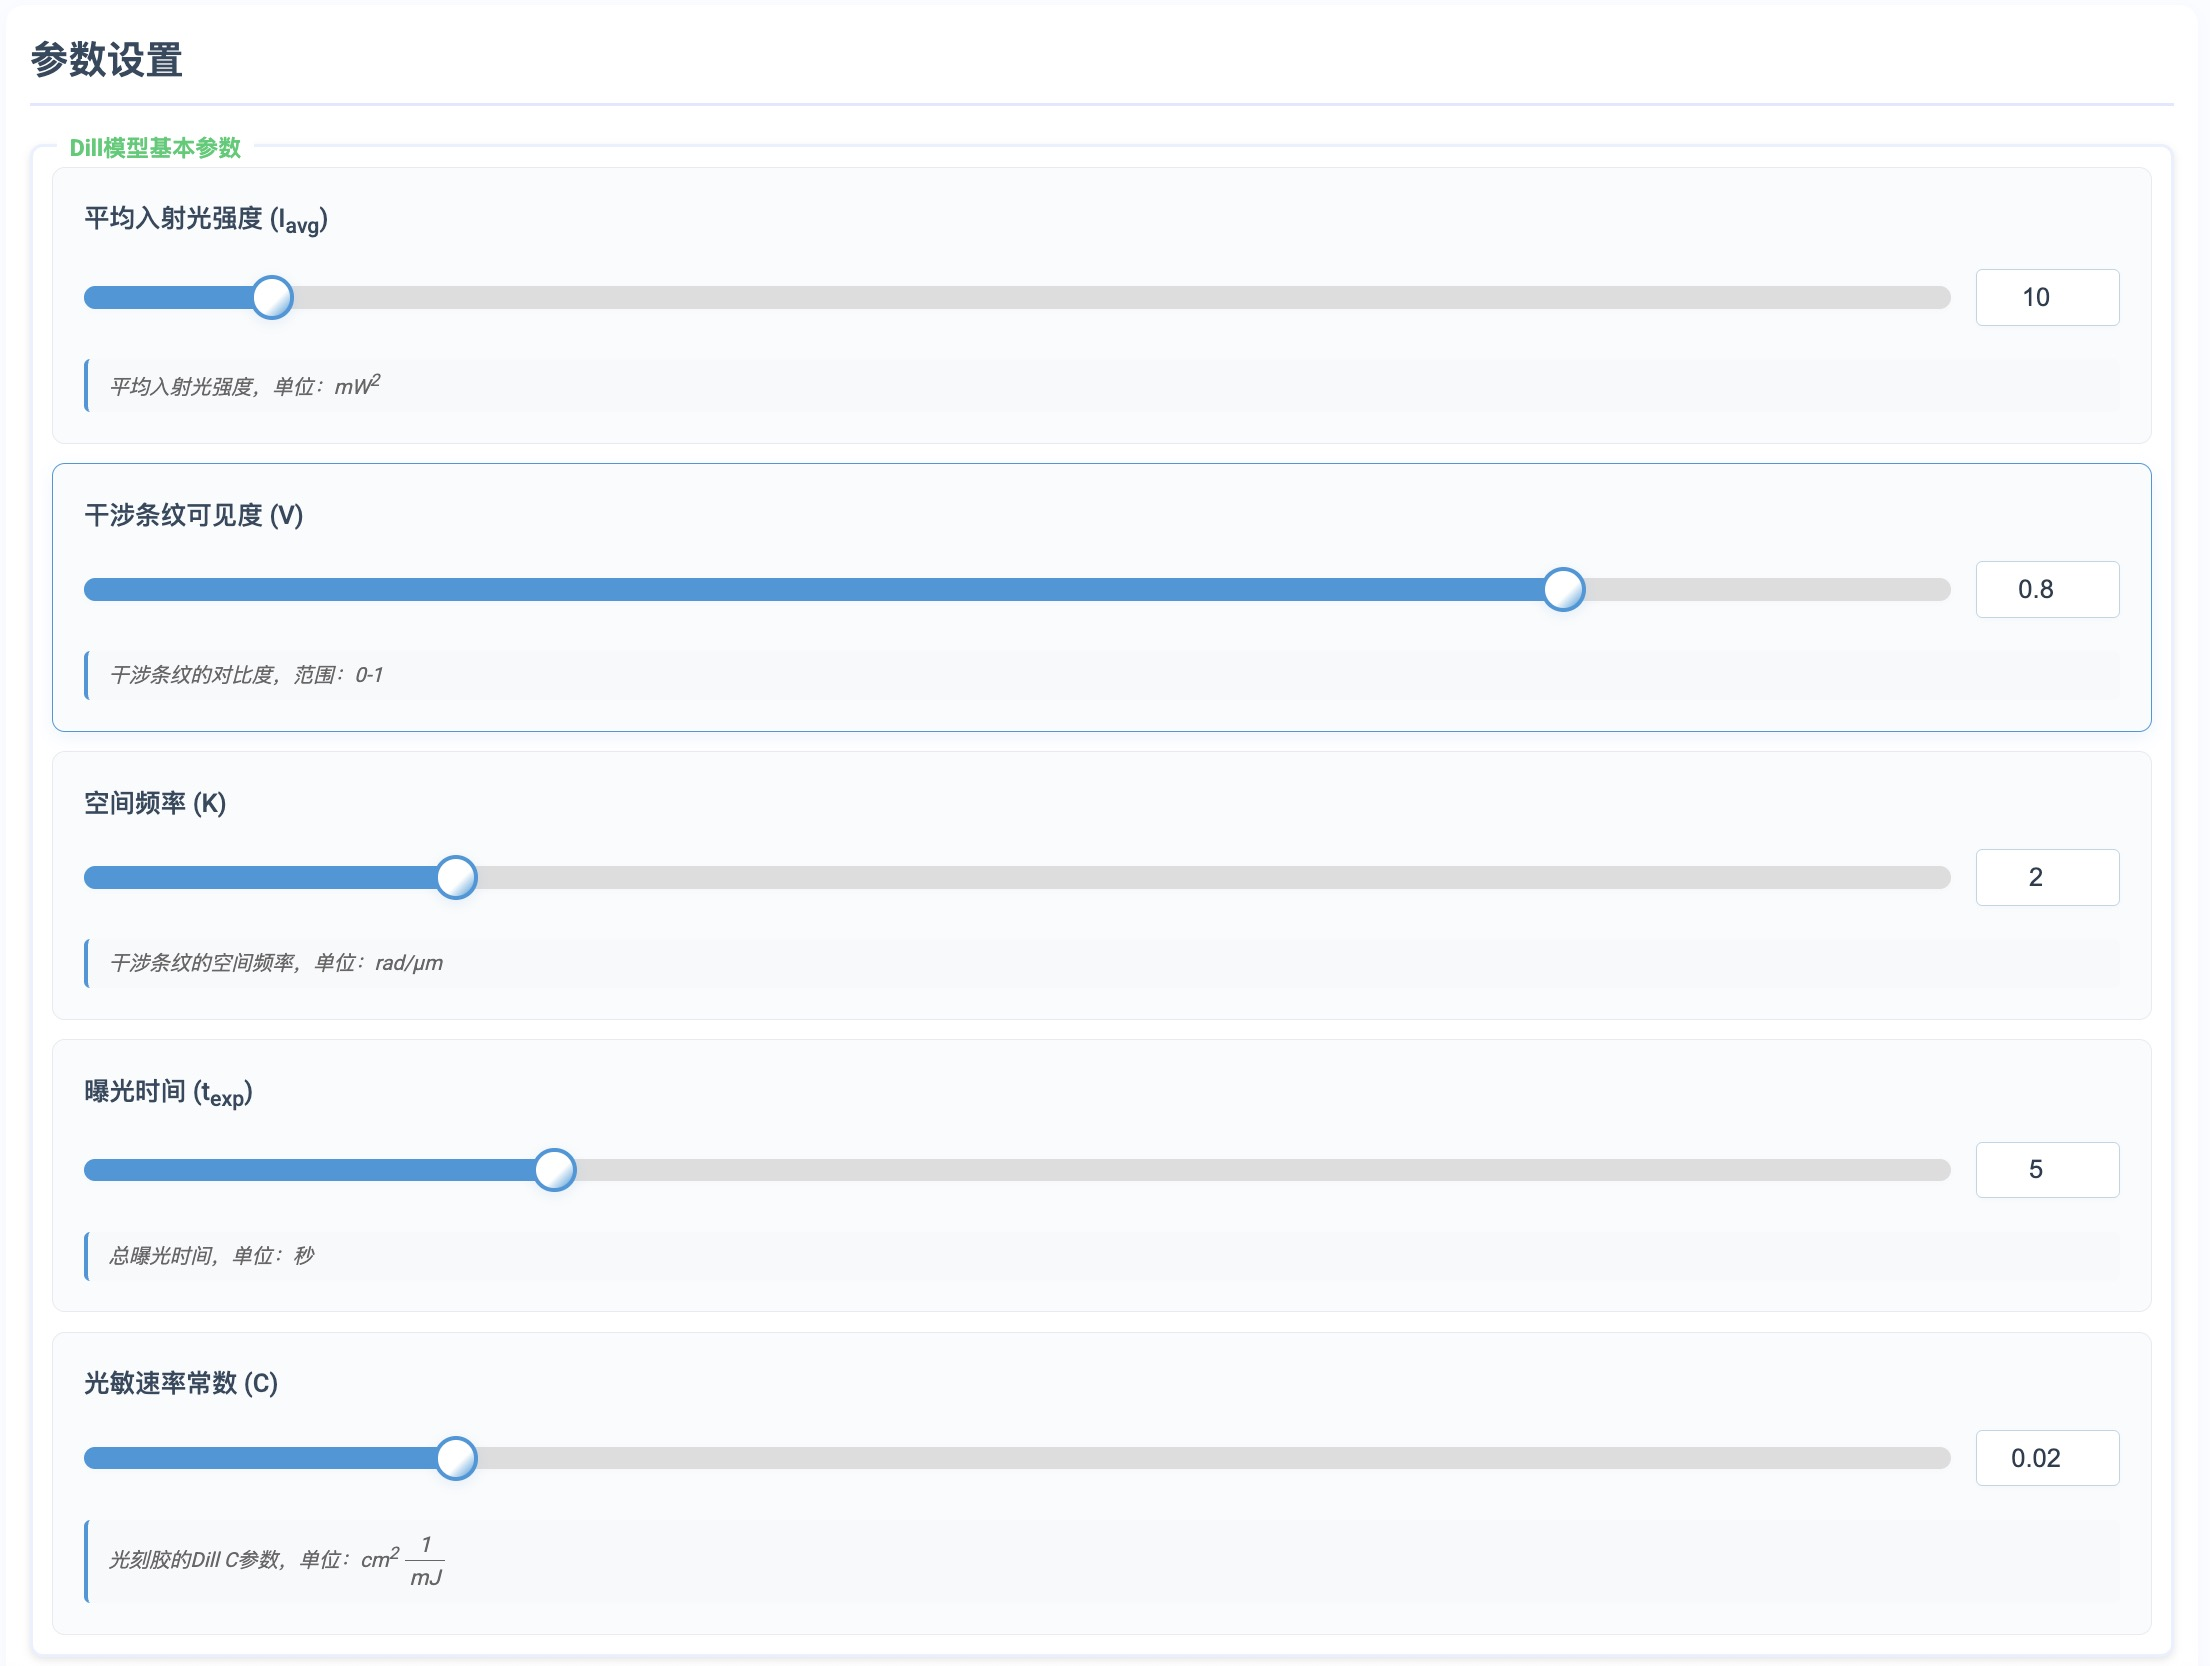

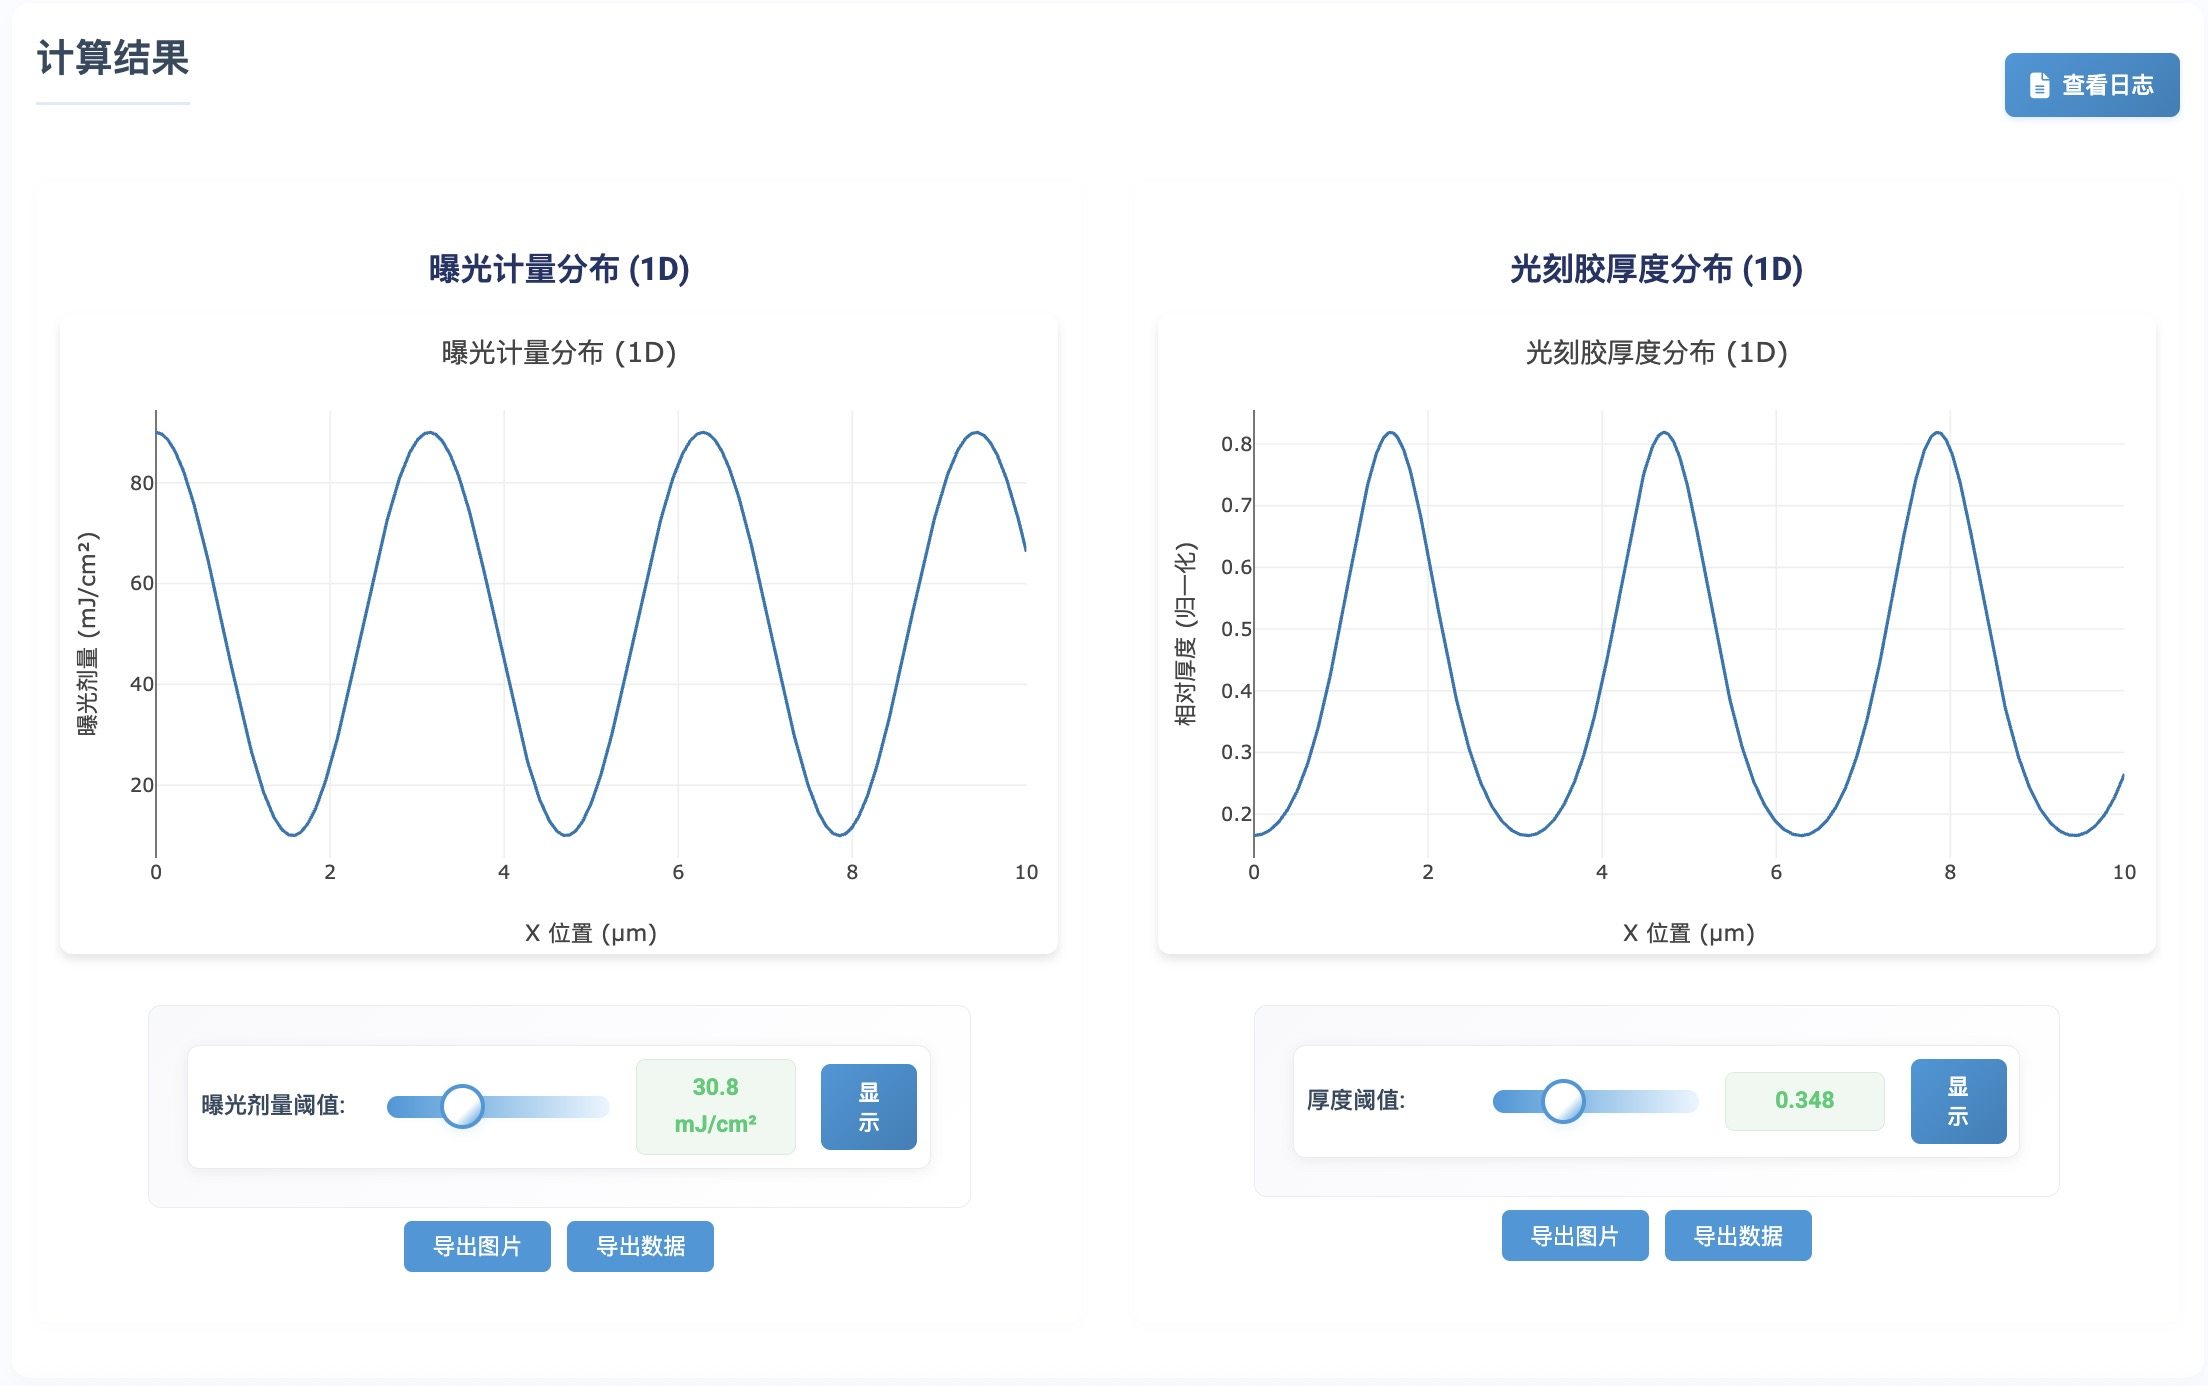

In [ ]:
# 后端代码实现 - enhanced_dill_model.py
def get_abc(self, z_h, T, t_B):
    """
    根据厚度z_h、前烘温度T、前烘时间t_B，拟合A/B/C参数
    """
    D = z_h  # 胶厚

    # A参数拟合公式
    A = (-0.11989 * D + 0.00466 * T + 0.00551 * D**2
         - 0.0001084 * D * T - 0.00001287 * T**2 + 0.79655)

    # B参数拟合公式
    B = 0.00066301 * D + 0.00024413 * T - 0.0096

    # C参数拟合公式
    C = (-0.01233 * D + 0.00054385 * T + 0.00056988 * D**2
         - 0.00001487 * D * T - 0.00000115 * T**2 + 0.0629)

    return A, B, C


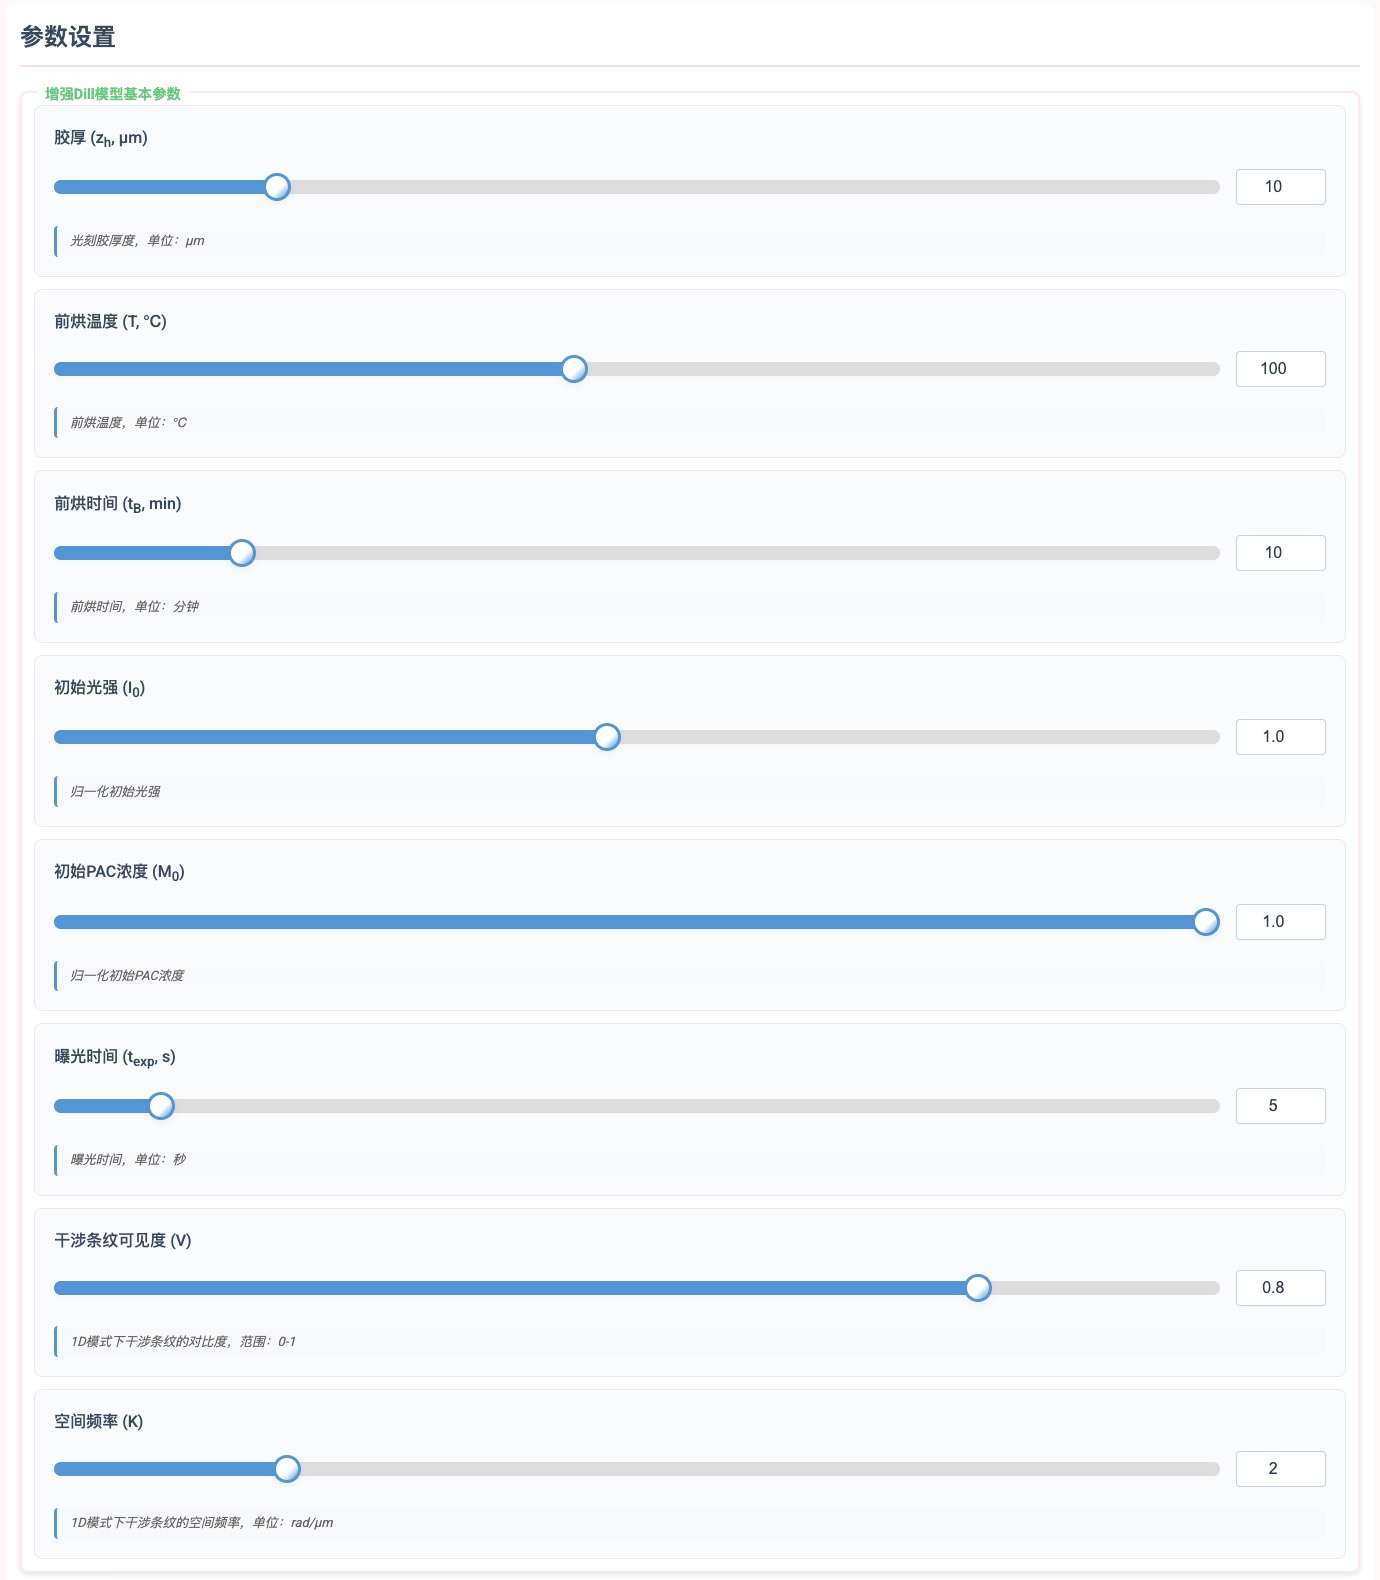

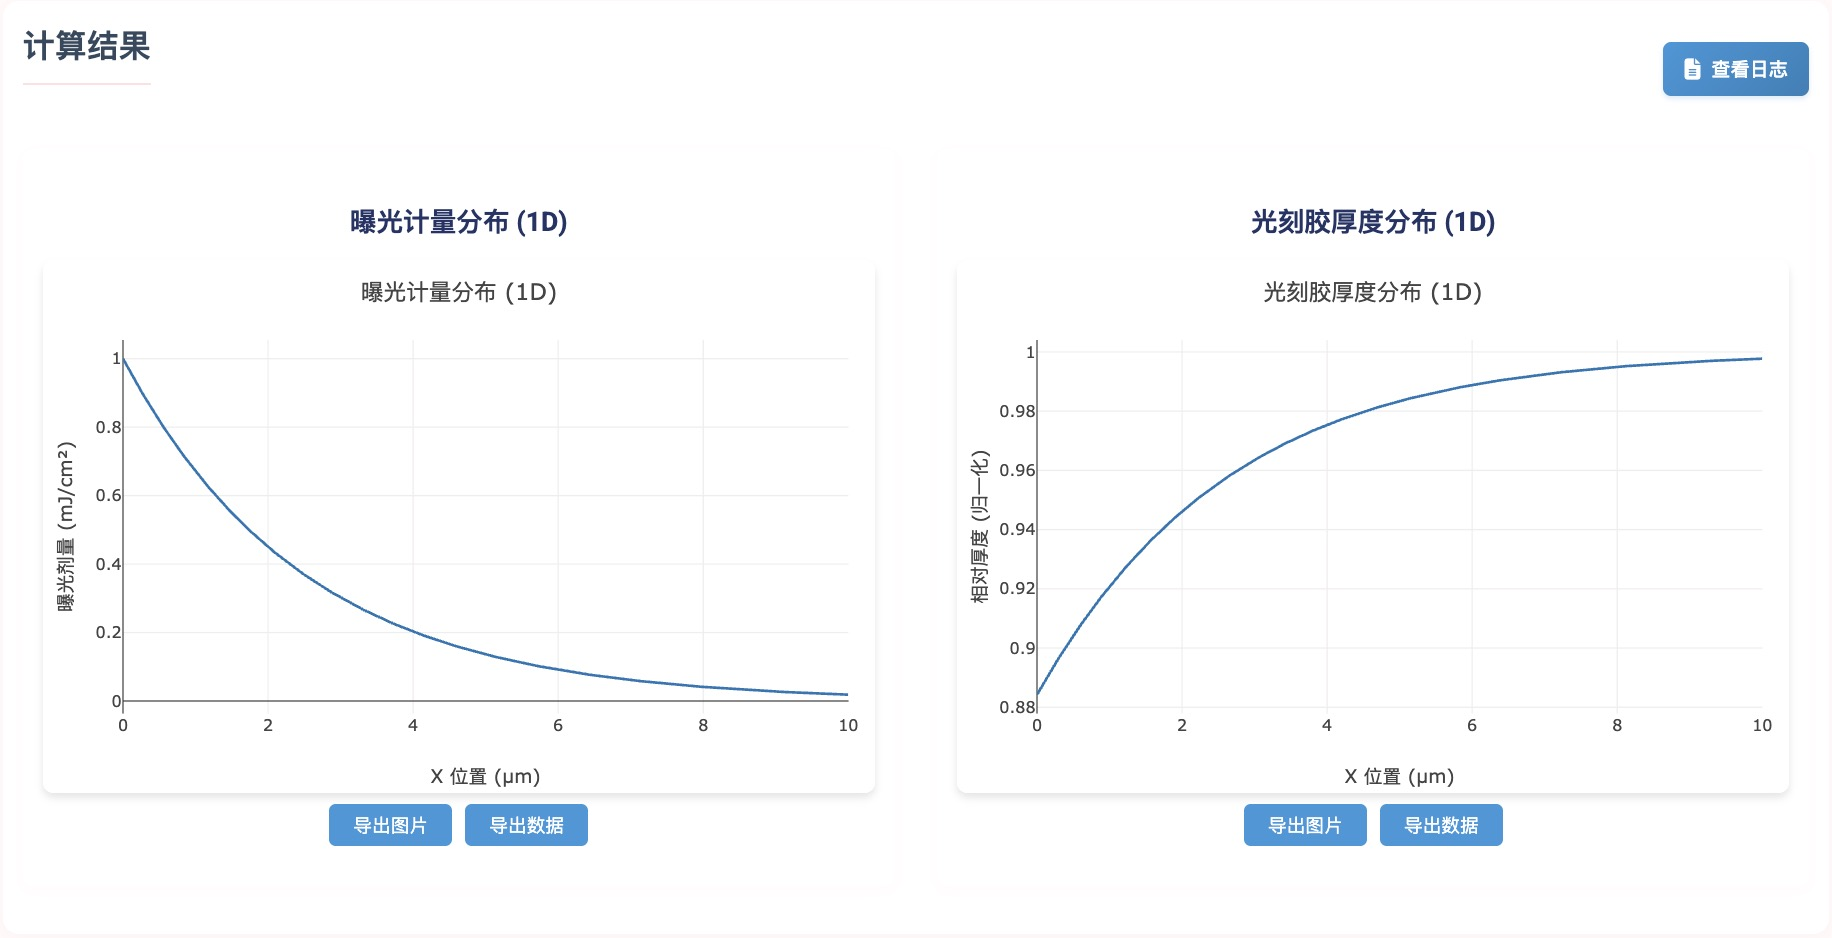  

In [ ]:
# 后端代码实现 - car_model.py
def calculate_acid_generation(self, x, I_avg, V, K=None, t_exp=1, acid_gen_efficiency=1, sine_type='1d', Kx=None, Ky=None, Kz=None, phi_expr=None, y=0, z=0):
    """
    计算初始光酸分布
    使用公式: [H+] = η * D(x) = η * I(x) * t_exp
    """
    # 计算曝光剂量
    exposure_dose = self.calculate_exposure_dose(x, I_avg, V, K, t_exp, sine_type, Kx, Ky, Kz, phi_expr, y, z)
    # 计算光酸浓度 = 光酸产生效率 * 曝光剂量
    acid_concentration = acid_gen_efficiency * exposure_dose
    return acid_concentration


In [ ]:
# 后端代码实现 - car_model.py
def simulate_acid_diffusion(self, acid_concentration, diffusion_length):
    """
    模拟光酸扩散过程
    使用高斯滤波模拟扩散：[H+]_diff = G([H+], l_diff)
    """
    if diffusion_length <= 0:
        return acid_concentration

    # 使用scipy的高斯滤波模拟扩散过程
    from scipy.ndimage import gaussian_filter1d
    diffused_acid = gaussian_filter1d(acid_concentration, sigma=diffusion_length, mode='reflect')
    return diffused_acid


In [ ]:
# 后端代码实现 - car_model.py
def calculate_deprotection(self, diffused_acid, reaction_rate, amplification):
    """
    计算脱保护反应
    使用公式: M = 1 - exp(-k * [H+]_diff * A)
    """
    # 归一化处理，确保输入在合理范围内
    normalized_acid = np.clip(diffused_acid, 0, 1)

    # 计算脱保护程度
    deprotection = 1 - np.exp(-reaction_rate * normalized_acid * amplification)

    # 确保结果在0-1范围内
    deprotection = np.clip(deprotection, 0, 1)

    return deprotection


In [ ]:
# 后端代码实现 - car_model.py
def calculate_dissolution(self, deprotection, contrast):
    """
    计算显影后的剩余光刻胶厚度
    使用公式: 剩余厚度 = 1 - (脱保护程度)^γ
    """
    # 使用非线性函数模拟显影过程的对比度
    thickness = 1 - np.power(deprotection, contrast)

    return thickness


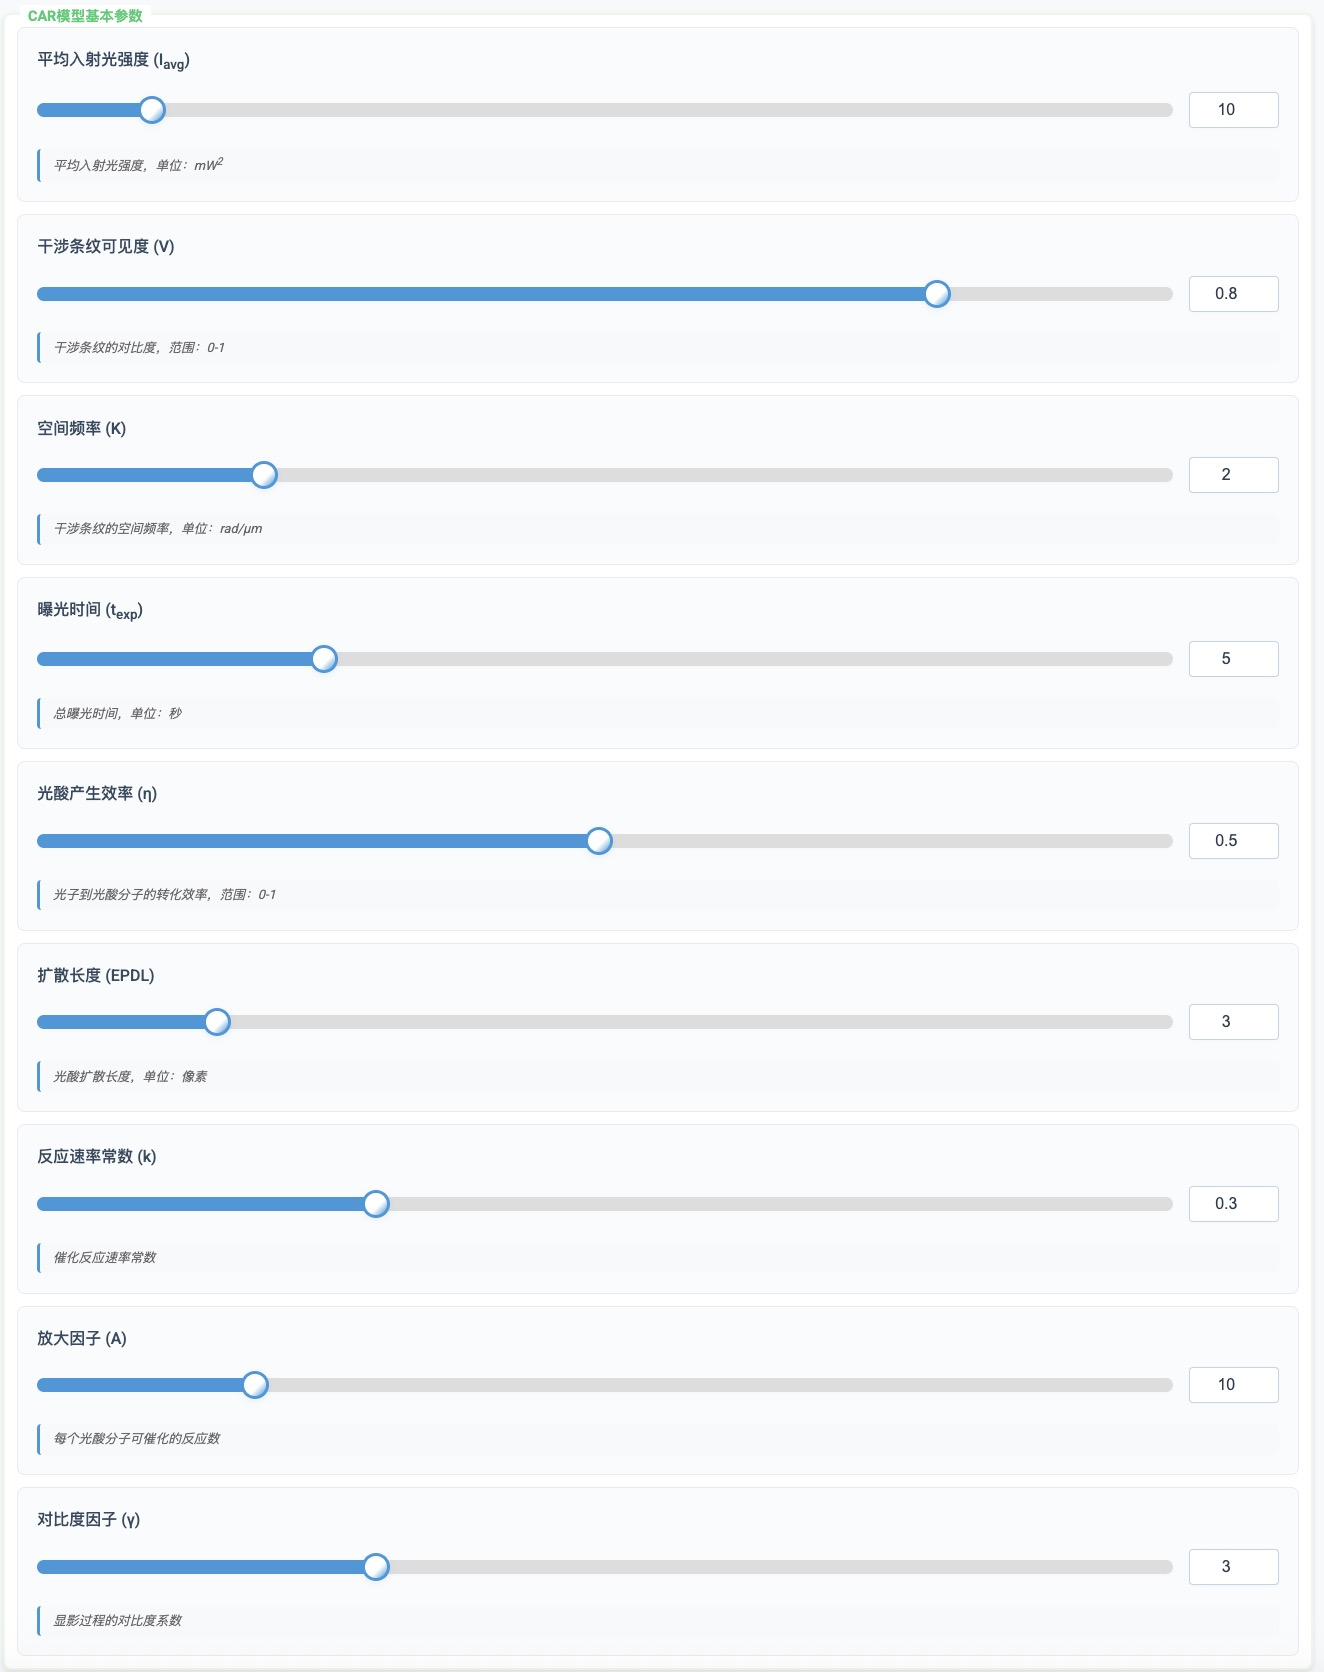

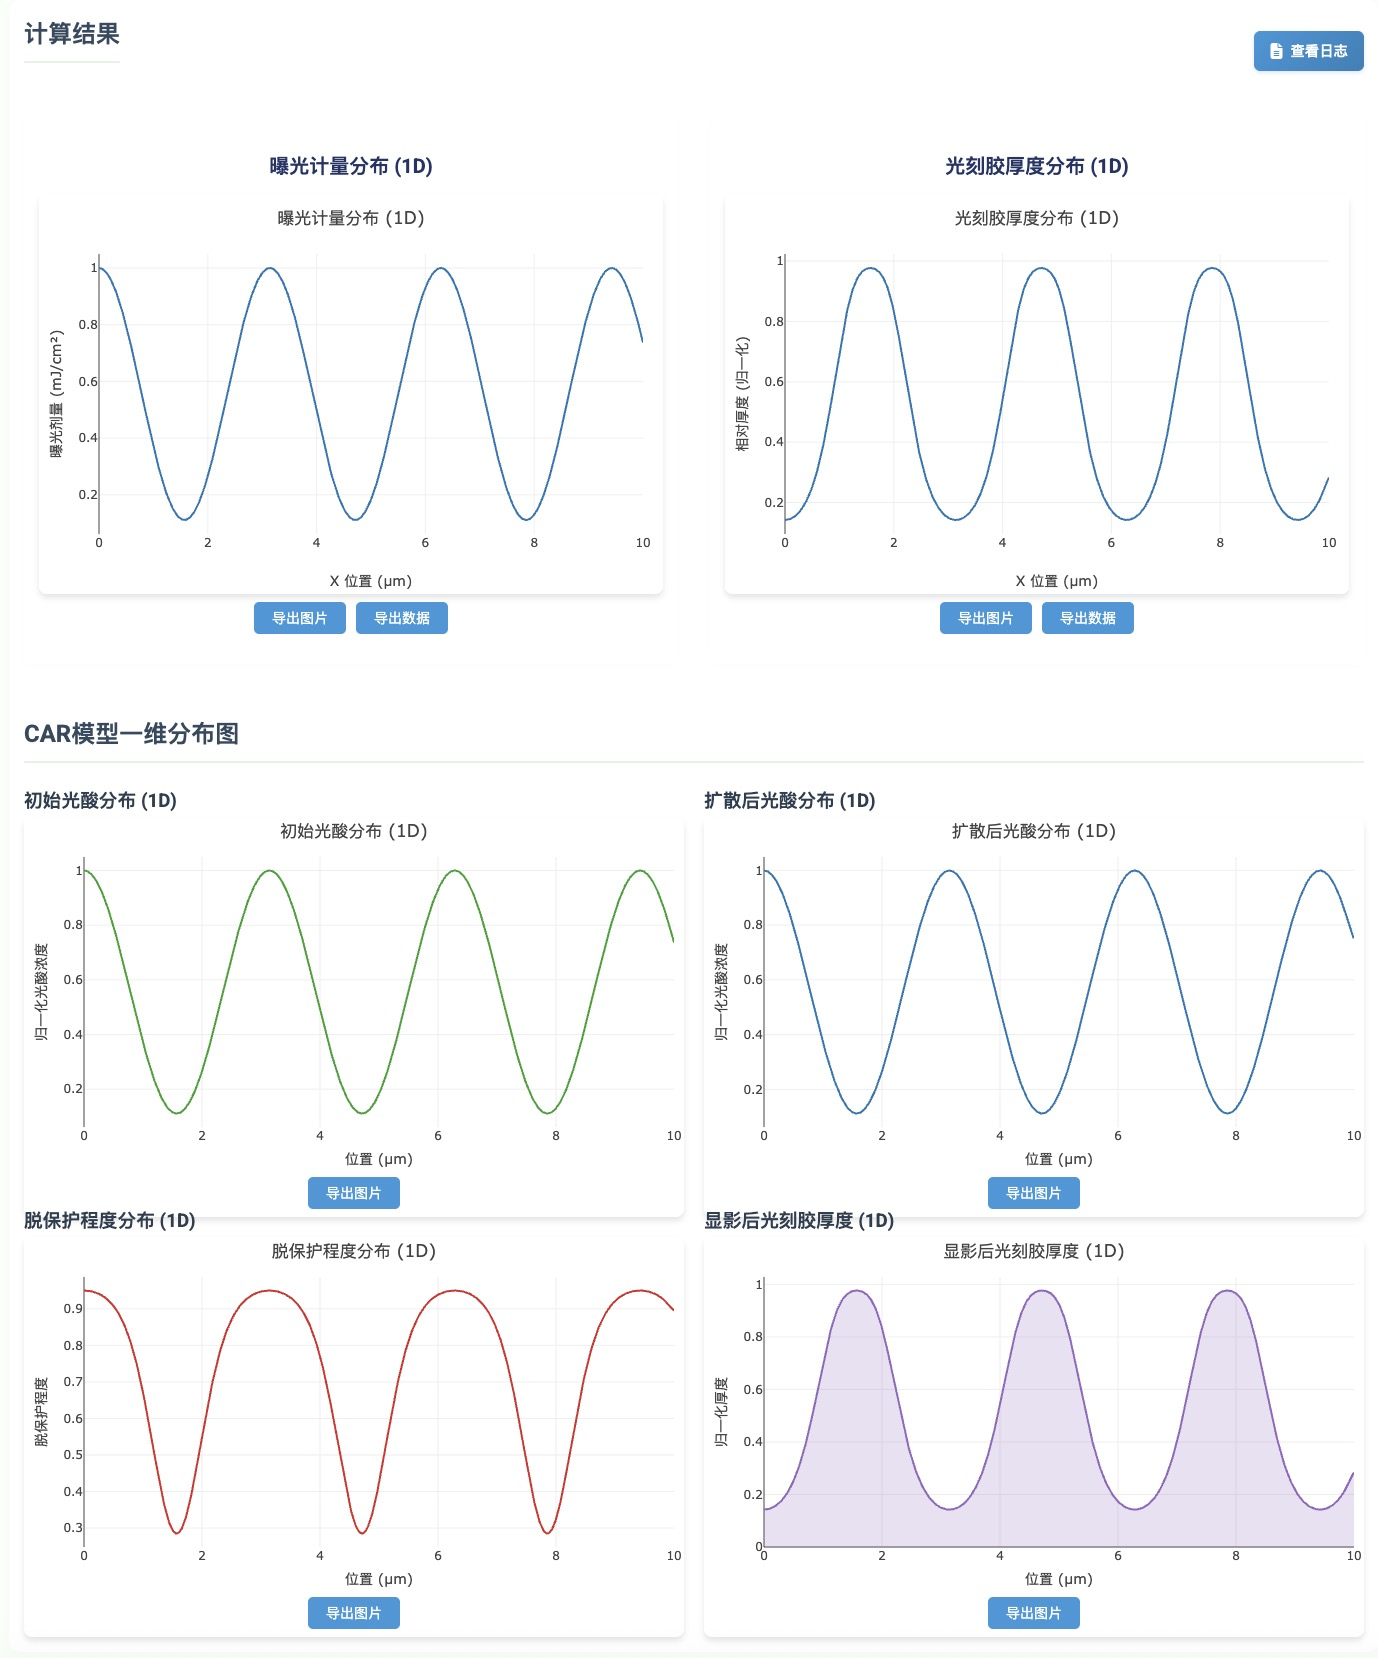

In [ ]:
# 后端代码实现 - dill_model.py (一维正弦波)
def calculate_intensity_distribution(self, x, I_avg, V, K=None, sine_type='1d', Kx=None, Ky=None, Kz=None, phi_expr=None, y=0, z=0, t=0):
    """一维正弦波光强分布计算"""
    if sine_type == '1d' or sine_type == 'single':
        # 使用公式: I(x) = I_avg * (1 + V * cos(K*x))
        result = I_avg * (1 + V * np.cos(K * x))
        return result


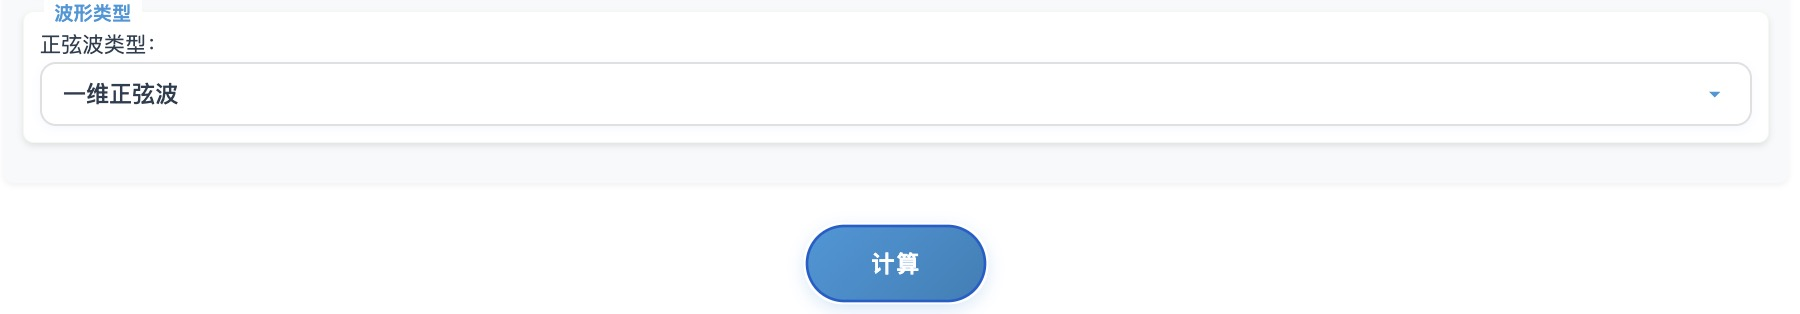

In [ ]:
# 后端代码实现 - dill_model.py (二维正弦波)
def calculate_intensity_distribution_2d(self, x, y, I_avg, V, Kx, Ky, phi_expr=None, t=0, z=0):
    """二维正弦波光强分布计算"""
    # 计算相位
    if phi_expr:
        # 支持复杂相位表达式，如 "Kx*x + Ky*y + t*w"
        phi = eval(phi_expr, {"Kx": Kx, "Ky": Ky, "x": x, "y": y, "z": z, "t": t, "np": np})
    else:
        phi = 0

    # 使用公式: I(x,y) = I_avg * (1 + V * cos(Kx*x + Ky*y + phi))
    result = I_avg * (1 + V * np.cos(Kx * x + Ky * y + phi))
    return result


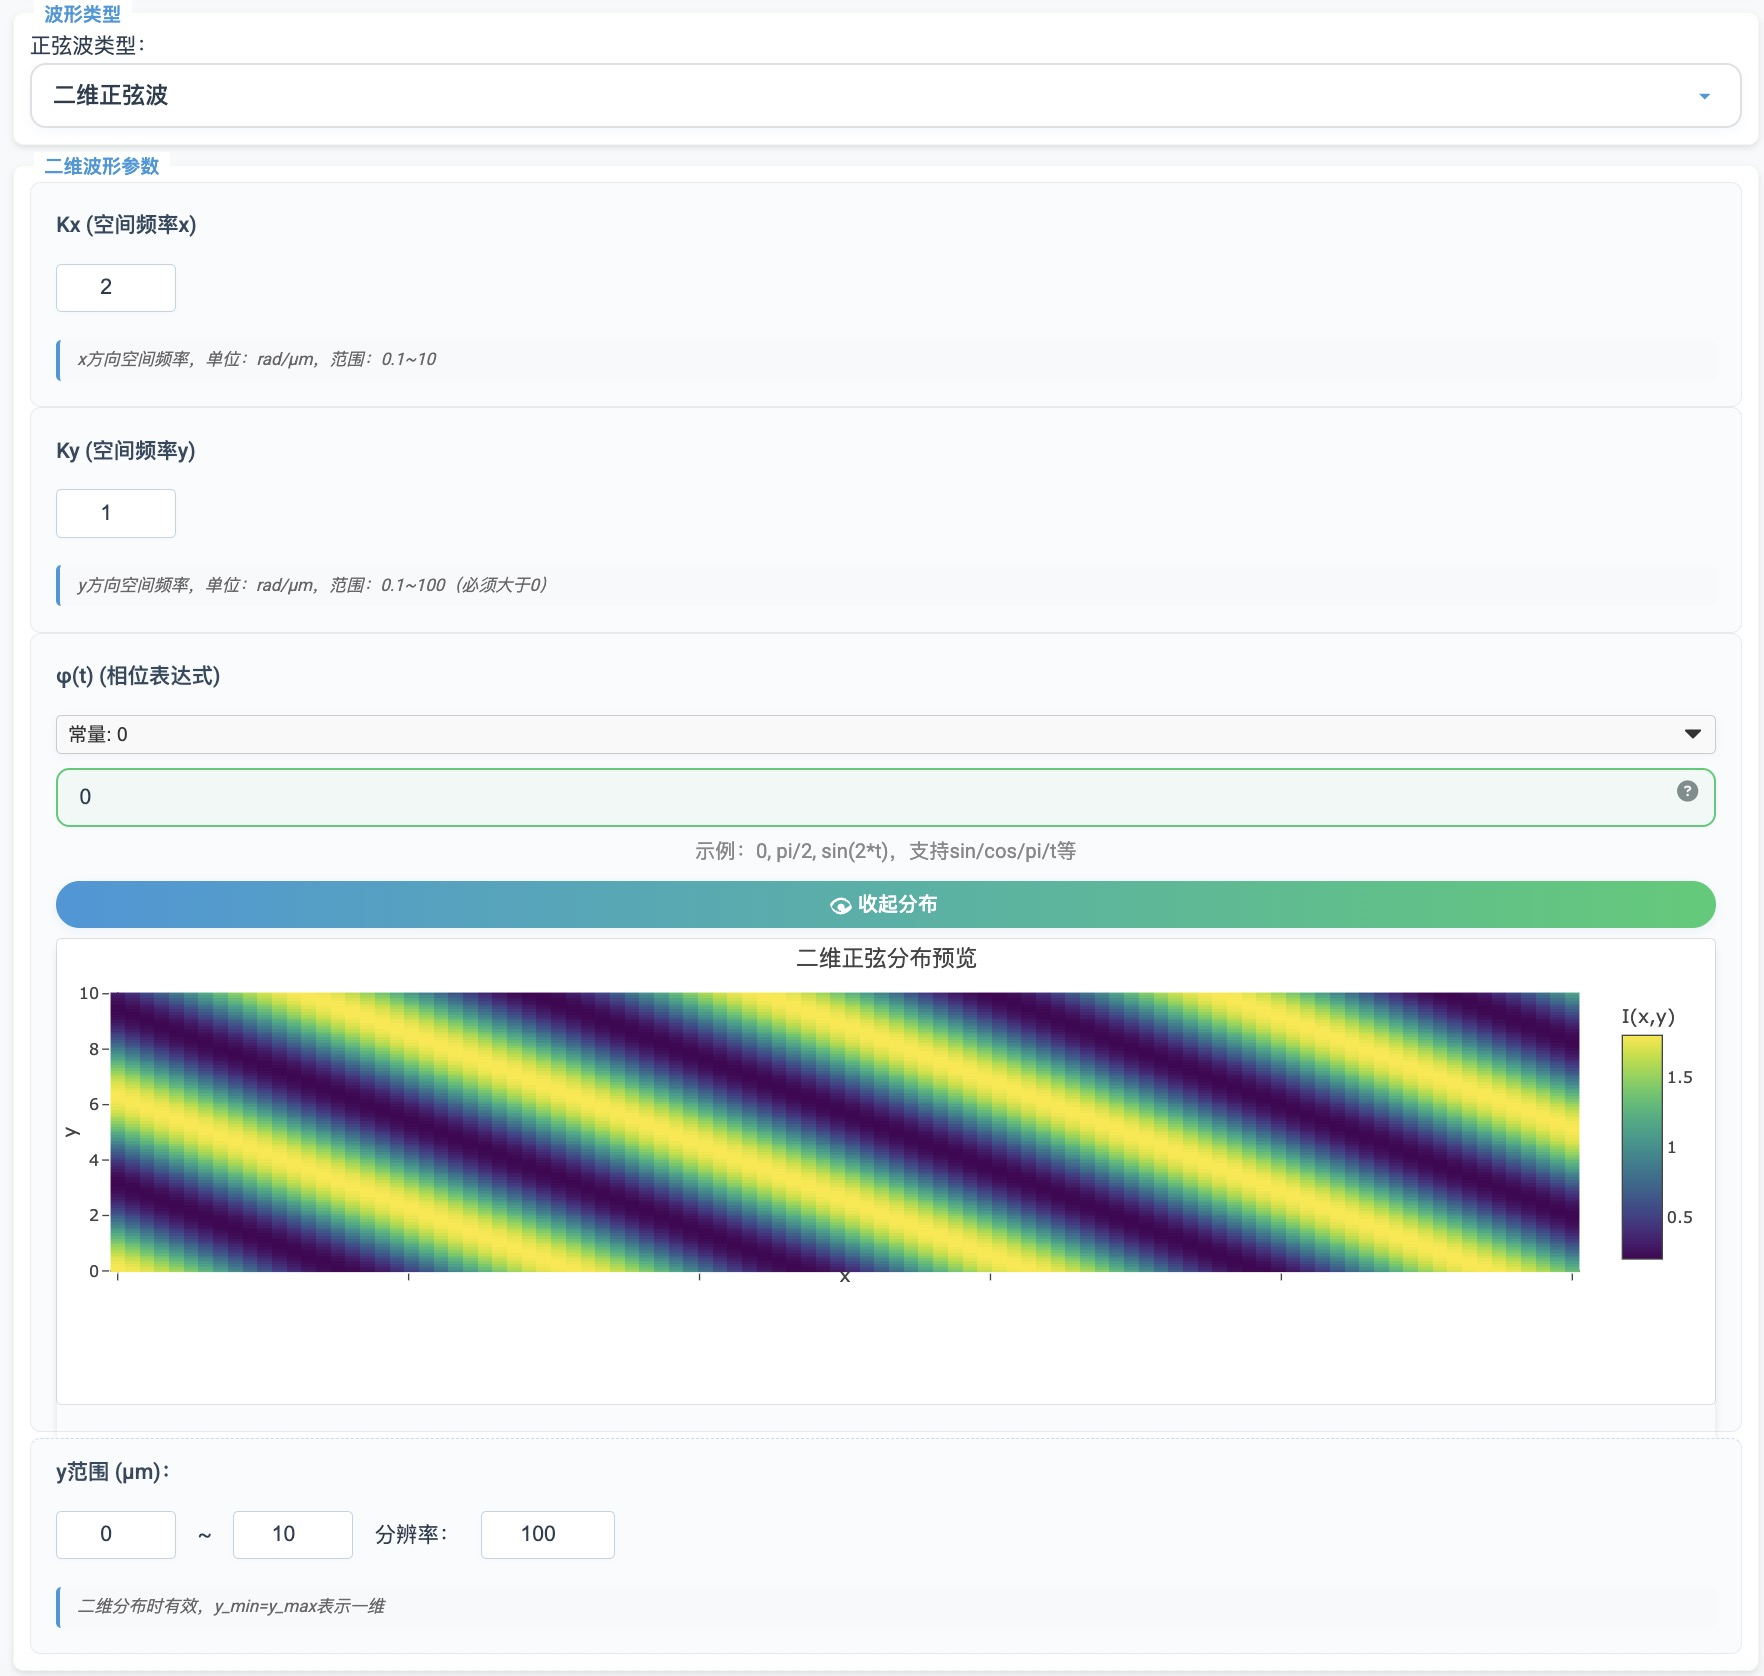

In [ ]:
# 后端代码实现 - dill_model.py (三维正弦波)
def calculate_intensity_distribution_3d(self, x, y, z, I_avg, V, Kx, Ky, Kz, phi_expr=None, t=0):
    """三维正弦波光强分布计算"""
    # 计算相位
    if phi_expr:
        # 支持复杂相位表达式，如 "Kx*x + Ky*y + Kz*z + t*w"
        phi = eval(phi_expr, {"Kx": Kx, "Ky": Ky, "Kz": Kz, "x": x, "y": y, "z": z, "t": t, "np": np})
    else:
        phi = 0

    # 使用公式: I(x,y,z) = I_avg * (1 + V * cos(Kx*x + Ky*y + Kz*z + phi))
    result = I_avg * (1 + V * np.cos(Kx * x + Ky * y + Kz * z + phi))
    return result


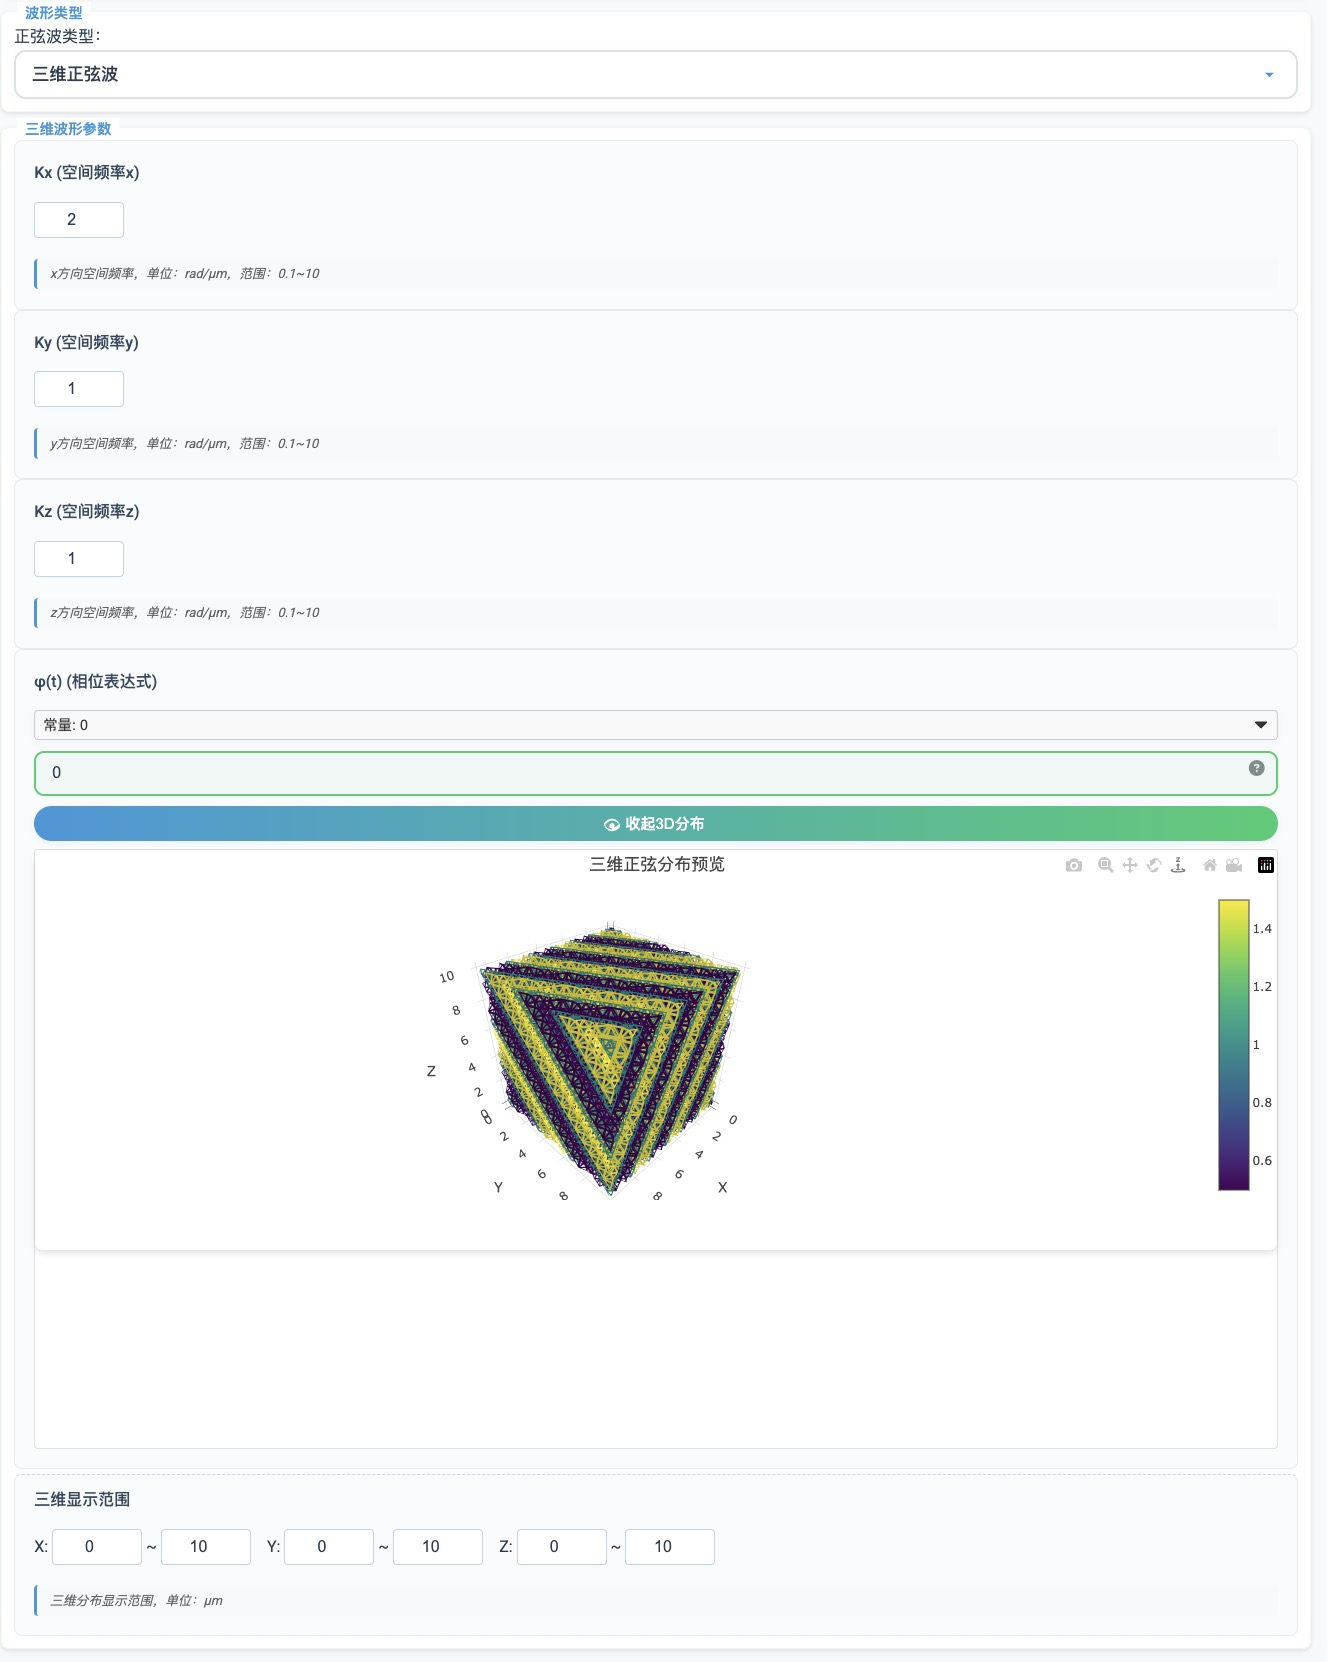

In [ ]:
// 前端代码实现 - frontend/js/sine_wave.js
function updateSineWaveInputs() {
    const sineType = document.getElementById('sine_type').value;
    const sineInputs = document.getElementById('sine_inputs');

    if (sineType === '1d') {
        // 一维正弦波：只需要K参数
        sineInputs.innerHTML = `
            <label>空间频率 K (rad/μm):</label>
            <input type="number" id="K" value="1" step="0.1">
        `;
    } else if (sineType === '2d') {
        // 二维正弦波：需要Kx, Ky, 相位表达式
        sineInputs.innerHTML = `
            <label>Kx (rad/μm):</label>
            <input type="number" id="Kx" value="1" step="0.1">
            <label>Ky (rad/μm):</label>
            <input type="number" id="Ky" value="1" step="0.1">
            <label>相位表达式:</label>
            <input type="text" id="phi_expr" placeholder="例: Kx*x + Ky*y">
        `;
    } else if (sineType === '3d') {
        // 三维正弦波：需要Kx, Ky, Kz, 相位表达式
        sineInputs.innerHTML = `
            <label>Kx (rad/μm):</label>
            <input type="number" id="Kx" value="1" step="0.1">
            <label>Ky (rad/μm):</label>
            <input type="number" id="Ky" value="1" step="0.1">
            <label>Kz (rad/μm):</label>
            <input type="number" id="Kz" value="1" step="0.1">
            <label>相位表达式:</label>
            <input type="text" id="phi_expr" placeholder="例: Kx*x + Ky*y + Kz*z">
        `;
    }
}
